#### ***Packages***

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import seaborn as sns

#### ***Data Preparation***

In [ ]:
df = pd.read_csv(r"file_path_of_decomposed_regionally_2060-2090.csv").iloc[:, 1:]  #Where we store the decomposed uncertainty 

In [4]:
uncert= {}
for code, group in df.groupby('code'):
    uncert[code] = group

In [5]:
data = {}
for key in uncert:
    data[key] = uncert[key].copy()

In [6]:
g = []
code = []

for k in data: 
    g.append(data[k]["gcm"].mean())
    code.append(k)

In [7]:
for key in data:
    df = data[key]
    df = df.apply(pd.to_numeric, errors='coerce')  
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    data[key][numeric_cols] = df[numeric_cols].clip(lower=0)

In [8]:
for key in data:
    data[key].drop(["gcm_T", "scenario_T", "method_T", "code"], axis = 1, inplace = True)
    data[key].set_index("year", inplace = True)

In [9]:
for key in data:
    data[key] = data[key]*100

In [10]:
for key in data:
    data[key] = data[key].rename(columns = {"gcm": "GCMs",
                                            "scenario": "Scenarios",
                                            "method": "Scaling Methods",
                                            "gcm:scenario": "GCMs x Scenarios",
                                            "gcm:method": "GCMs x Scaling Methods",
                                            "scenario:method": "Scenarios x Scaling Methods"})

In [12]:
final_df = pd.DataFrame(index=data['AMZ'].index, columns=data['AMZ'].columns)

for col in final_df.columns:
    column_data = [data[key][col] for key in data]
    final_df[col] = pd.concat(column_data, axis=1).mean(axis=1)

#### ***Plotting***

C:\Users\USER2\AppData\Local\Temp\ipykernel_22824\770614986.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


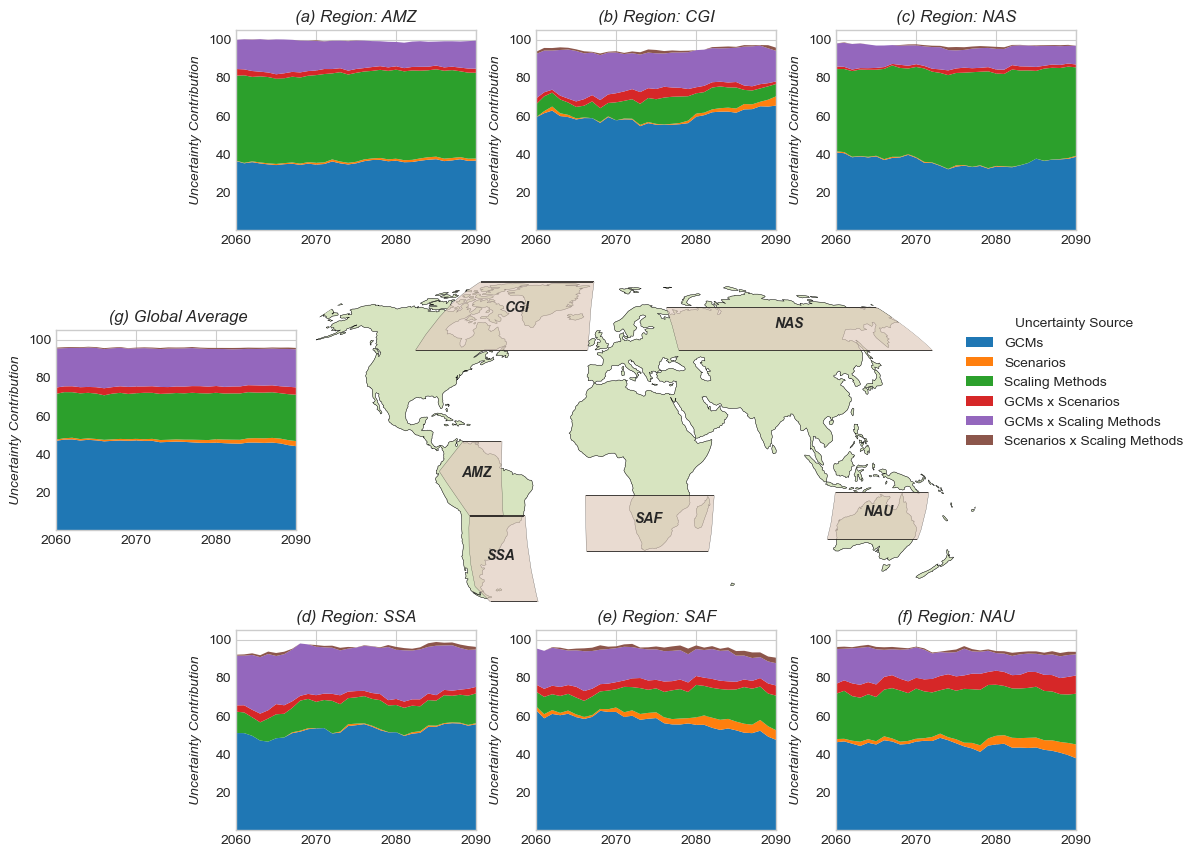

In [13]:
shapefile_path = r"shape_file.shp"  # Shapefile of SREX regions
gdf_shapefile = gpd.read_file(shapefile_path)

indices_to_drop = [3, 27, 28, 29, 30, 31, 32]
gdf_shapefile = gdf_shapefile.drop(indices_to_drop)
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(30, 25))
ax = fig.add_subplot(335, projection=ccrs.Robinson())
ax.set_extent([-150, 180, -60, 90], crs=ccrs.PlateCarree())

land = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                    edgecolor='black',
                                    facecolor='#D7E4C0', linewidth=0.3)
ax.add_feature(land)


highlight_regions = ["AMZ", "CGI", "NAU", "SSA", "SAF","NAS"]
for geom, lab in zip(gdf_shapefile['geometry'], gdf_shapefile['LAB']):
    if lab in highlight_regions:
        color = "#E0CCBE"
        alpha = 0.7
        ax.add_geometries([geom], crs=ccrs.PlateCarree(), facecolor=color, edgecolor='black', linewidth=0.2, zorder=4, alpha=alpha)
        centroid = geom.centroid
        ax.text(centroid.x, centroid.y, lab, fontsize=10, ha='center', transform=ccrs.PlateCarree(), zorder=4, style="italic", fontweight = "bold")

ax.set_frame_on(False)
ax.coastlines(linewidth=0.1)
ax.grid(True)

colors = sns.color_palette(["#5097D2","#9C2AF2", "#F1552B", "#F3DB29",  "#6ABD45", "#F254DB"])

def plot_area(ax, data, colors):
    cum_data = data.cumsum(axis=1)
    for i, column in enumerate(data.columns):
        ax.fill_between(data.index, cum_data[column], cum_data[column] - data[column],  label=column)
    ax.set_xlim(data.index.min(), data.index.max())
    ticks = ax.get_yticks()
    ax.set_yticks([tick for tick in ticks if tick != 0])  
    ax.set_ylim(0, 105)  

# Subplots for data
ax2 = fig.add_axes([0.38, 0.34, 0.08, 0.08])
plot_area(ax2, data["SSA"], colors)
ax2.set_title('(d) Region: SSA', style="italic")
ax2.grid(True)
ax2.set_ylabel('Uncertainty Contribution', style="italic")

ax3 = fig.add_axes([0.38, 0.58, 0.08, 0.08])
plot_area(ax3, data["AMZ"], colors)
ax3.set_title('(a) Region: AMZ', style="italic")
ax3.grid(True)
ax3.set_ylabel('Uncertainty Contribution', style="italic")

ax4 = fig.add_axes([0.58, 0.34, 0.08, 0.08])
plot_area(ax4, data["NAU"], colors)
ax4.set_title('(f) Region: NAU', style="italic")
ax4.grid(True)
ax4.set_ylabel('Uncertainty Contribution', style="italic")

ax5 = fig.add_axes([0.58, 0.58, 0.08, 0.08])
plot_area(ax5, data["NAS"], colors)
ax5.set_title('(c) Region: NAS', style="italic")
ax5.grid(True)
ax5.set_ylabel('Uncertainty Contribution', style="italic")

ax6 = fig.add_axes([0.32, 0.46, 0.08, 0.08])
plot_area(ax6, final_df, colors)
ax6.set_title(' (g) Global Average', style="italic")
ax6.grid(True)
ax6.set_ylabel('Uncertainty Contribution', style="italic")

ax7 = fig.add_axes([0.48, 0.34, 0.08, 0.08])
plot_area(ax7, data["SAF"], colors)
ax7.set_title('(e) Region: SAF', style="italic")
ax7.grid(True)
ax7.set_ylabel('Uncertainty Contribution', style="italic")

ax8 = fig.add_axes([0.48, 0.58, 0.08, 0.08])
plot_area(ax8, data["CGI"], colors)
ax8.set_title('(b) Region: CGI', style="italic")
ax8.grid(True)
ax8.set_ylabel('Uncertainty Contribution', style="italic")

# Legend for area colors
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.7, 0.55), title='Uncertainty Source')

plt.savefig("save_path.png", bbox_inches = "tight", dpi = 300)
plt.show()